## Imports

In [13]:
import copy
import math
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import imageio
colors = sns.color_palette('hls',20)

%matplotlib inline

## Get Group of HDF5 File

In [3]:
def get_group(file):
    
    with h5py.File(file, mode="r") as f:
        print("Keys",len(f.keys()))
        for group in f.keys():
            print("Group:",group, type(f[group]))
            if isinstance(f[group], h5py.Dataset):
                num_sub = f[group].shape
                print("No: of subgroup:", num_sub)
                if num_sub:
                    print("--------------------------------------")
                    for col in f[group]:
                        print("SubGroup:",col," with Shape:",col.shape)
                    print("--------------------------------------")
            else:
                num_sub = len(f[group])
                print("No: of subgroup:", num_sub)
                if num_sub:
                    print("--------------------------------------")
                    for col in f[group]:
                        print("SubGroup:",col," with Shape:",len(f[group][col]))
                    print("--------------------------------------")
            break
    f.close()

## Memory Calculation

In [4]:
units = {
    0: 'B',
    1: 'KiB',
    2: 'MiB',
    3: 'GiB',
    4: 'TiB'
}


def format_mem(x):
    """
    Takes integer 'x' in bytes and returns a number in [0, 1024) and
    the corresponding unit.

    """
    if abs(x) < 1024:
        return round(x, 2), 'B'

    scale = math.log2(abs(x)) // 10
    scaled_x = x / 1024 ** scale
    unit = units[scale]

    if int(scaled_x) == scaled_x:
        return int(scaled_x), unit

    # rounding leads to 2 or fewer decimal places, as required
    return round(scaled_x, 2), unit

def print_tensor_mem(x, id_str=None):
    """
    Prints the memory required by tensor 'x'.

    """

    desc = 'memory'

    if id_str is not None:
        desc += f' ({id_str})'

    desc += ':'

    val, unit = format_mem(x.element_size() * x.nelement())

    print(f'{desc} {val}{unit}')

## Animation Dedalus

In [5]:
def animate(gif, foldername):
    with imageio.get_writer(gif, mode='I', fps=1) as writer:
         for index,file in enumerate(os.listdir(foldername)):
            image = imageio.v2.imread(os.path.join(foldername,file))
            writer.append_data(image)

## Kinetic Energy Spectrum
Ref: [Formula](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/energy-flux-spectrum-of-internal-waves-generated-by-turbulent-convection/D48AFFD90E089CA23E535CFF2388C8CC#s2),[Code](https://github.com/jdppthk/DDP_UNet/blob/master/data_process/ke_spectrum.py) 

In [5]:
def get_KESpectrum(field):

    u_x = field[0] # [Nx,Nz]
    u_z = field[1] # [Nx,Nz]
    eps = 1e-50 # to void log(0)

    # Compute the N-dimensional discrete Fourier Transform using FFT
    Ux_ampl = np.abs(np.fft.fftn(u_x)/u_x.size) # size = Nx*Nz
    Uz_ampl = np.abs(np.fft.fftn(u_z)/u_z.size) # size = Nx*Nz

    EK_Ux  = Ux_ampl**2
    EK_Uz  = Uz_ampl**2
    
    # Shift the zero-frequency component to the center of the spectrum.
    EK_Ux = np.fft.fftshift(EK_Ux)  # [Nx,Nz]
    EK_Uz = np.fft.fftshift(EK_Uz)  # [Nx,Nz]

    signal_sizex = np.shape(EK_Ux)[0] # [Nx]
    signal_sizey = np.shape(EK_Uz)[1] # [Nz]

    box_sidex = signal_sizex
    box_sidey = signal_sizey

    box_radius = int(np.ceil((np.sqrt((box_sidex)**2+(box_sidey)**2))/2.)+1)

    center_x = int(box_sidex/2)
    center_y = int(box_sidey/2)
    EK_Ux_avgsphr = np.zeros(box_radius,)+eps # size of the radius
    EK_Uz_avgsphr = np.zeros(box_radius,)+eps # size of the radius

    for i in range(box_sidex):
        for j in range(box_sidey):
            index =  int(np.round(np.sqrt((i-center_x)**2+(j-center_y)**2)))
            EK_Ux_avgsphr[index] = EK_Ux_avgsphr [index] + EK_Ux [i,j]
            EK_Uz_avgsphr[index] = EK_Uz_avgsphr [index] + EK_Uz [i,j]

    EK_avgsphr = 0.5*(EK_Ux_avgsphr + EK_Uz_avgsphr)

    return EK_avgsphr

In [28]:
def plot_KE(energy, time, path, start=0, stop=50, jump=1, legend=True, nx=64, nz=64, Pr=1, Ra=10e4):
    fig, ax = plt.subplots()
    ax.set_prop_cycle('color', colors)
    for i in range(start,stop,jump):
        ax.semilogy(energy[i][:], label=f't={np.round(time[i],2)}')
    if legend:
        ax.legend()
    ax.set_title(f"Kinetic Enegry Spectrum for RBC2D with NX={nx}, NZ={nz}, Pr={Pr}, Ra={Ra}")
    ax.set_xlabel("K")
    ax.set_ylabel("Kinetic Energy")
    ax.grid()
    fig.show()
    plt.savefig(f"{path}/energy.png")

## Timestep

In [8]:
def timestepfinder(file,indexrange,sample=0, typeval='single'):
    ke_energy = []
    simtime = []
    vel = []
    b = []
    p = []
    timestep = []
    walltime = []
    iteration_no = []
    writeno = []
    for t in range(indexrange):
        vel_t,b_t,v_t,p_t = rbc_tasks(typeval,file, t, sample , 0)
        write_no, iteration, sim_time, time_step, wall_time = rbc_scales(typeval, file, t,sample)
        writeno.append(write_no)
        walltime.append(wall_time)
        iteration_no.append(iteration)
        timestep.append(time_step)
        b.append(np.linalg.norm(b_t))
        p.append(np.linalg.norm(p_t))
        vel.append(np.linalg.norm(vel_t))
        ke_energy.append(get_KESpectrum(vel_t))
        simtime.append(sim_time)
    ke_energy = np.array(ke_energy)
    print(ke_energy.shape, len(simtime))
    return ke_energy, simtime, timestep, iteration_no, writeno, walltime

## Rayleigh-Bernard Data

In [7]:
def rbc_tasks(mode, filename,time=0,index=0, ind1=0,):
    with h5py.File(filename, mode="r") as f:
        if mode == 'single':
            # b_0 = f["tasks"]["buoyancy"][ind1]
            # v_0 = f["tasks"]["vorticity"][ind1]
            # vel_0 = f["tasks"]["velocity"][ind1]
            # p_0 = f["tasks"]["pressure"][ind1]
            b_t = f["tasks/buoyancy"][time]
            v_t = f["tasks/vorticity"][time]
            vel_t = f["tasks/velocity"][time]
            p_t = f["tasks/pressure"][time]
            
            # print(f"Index {ind1}\n buoyancy: \n{b_0}\n vorticity: \n{v_0}\n velocity: \n{vel_0}")
            # print(f"Index {ind2}\n buoyancy: \n{b_t}\n vorticity: \n{v_t}\n velocity: \n{vel_t}"    
            # return vel_0,vel_t,b_0,b_t,v_0,v_t,p_0, p_t
            
        else:
            vel_t = f[f'snapshots_{index}_t_{time}/tasks/velocity_t'][:] 
            b_t = f[f'snapshots_{index}_t_{time}/tasks/buoyancy_t'][:]
            v_t = f[f'snapshots_{index}_t_{time}/tasks/vorticity_t'][:]
            p_t = f[f'snapshots_{index}_t_{time}/tasks/pressure_t'][:]

        
    f.close()
  
    return vel_t,b_t,v_t, p_t
    # return vel_t,b_t,v_t

In [8]:
def rbc_scales(mode, filename,time=0, index=0):
    with h5py.File(filename, mode="r") as f:
        if mode == 'single':
            iteration = f["scales/iteration"][time]
            sim_time  = f["scales/sim_time"][time]
            time_step = f["scales/timestep"][time]
            wall_time = f["scales/wall_time"][time]
            write_no = f["scales/write_number"][time]
        else:
            iteration = f[f'snapshots_{index}_t_{time}/scales/iteration'][()]
            sim_time = f[f'snapshots_{index}_t_{time}/scales/sim_time'][()]
            time_step = f[f'snapshots_{index}_t_{time}/scales/timestep'][()]
            wall_time = f[f'snapshots_{index}_t_{time}/scales/wall_time'][()]
            write_no = f[f'snapshots_{index}_t_{time}/scales/write_number'][()]

        # print("Constant", f["scales/constant"][:].shape)
        # print("Iteration", f["scales/iteration"][:].shape)
        # print("Simulation Time", f["scales/sim_time"][:].shape)
        # print("timestep", f["scales/timestep"][:].shape)
        # print("Wall time", f["scales/wall_time"][:].shape)
        # print("write number", f["scales/write_number"][:].shape)
        # print("X", f["scales/x_hash_259ff677ed0cf648980d6e69fe3d2deb0dc82141"][:].shape)
        # print("Z", f["scales/z_hash_2b3e6c1ad6197e7bbb577c37c9be3babe1727daf"][:].shape)   
        
    f.close()
    return write_no, iteration, sim_time, time_step, wall_time

In [9]:
def data_process(filename, foldername, start_t, end_t):
    index = 0
    with h5py.File(filename, "w") as data:
        for n,file in enumerate(sorted(os.listdir(foldername))):
            print("Data:",file)
            for time in range(start_t,end_t):
                t = time + n*end_t
             
                # vel_0, vel_t,b_0,b_t,v_0,v_t = rbc_tasks('single', os.path.join(foldername,file),t,0,0)
                vel_t, b_t, v_t, p_t = rbc_tasks('single', os.path.join(foldername,file), time, 0,0)
                # vel_t, b_t, v_t = rbc_tasks('single', os.path.join(foldername,file), t, 0,0)
                write_no, iteration, sim_time, time_step, wall_time = rbc_scales('single', os.path.join(foldername,file), time,0)
                data[f'snapshots_{index}_t_{t}/scales/iteration'] = iteration
                data[f'snapshots_{index}_t_{t}/scales/sim_time'] = sim_time
                data[f'snapshots_{index}_t_{t}/scales/timestep'] = time_step
                data[f'snapshots_{index}_t_{t}/scales/wall_time'] = wall_time
                data[f'snapshots_{index}_t_{t}/scales/write_number'] = write_no

                # data[f'snapshots_{index}_t_{t}/velocity_0'] = vel_0
                # data[f'snapshots_{index}_t_{t}/tasks/buoyancy_0'] = b_0
                # data[f'snapshots_{index}_t_{t}/tasks/vorticity_0'] = v_0

                data[f'snapshots_{index}_t_{t}/tasks/velocity_t'] = vel_t
                data[f'snapshots_{index}_t_{t}/tasks/buoyancy_t'] = b_t
                data[f'snapshots_{index}_t_{t}/tasks/vorticity_t'] = v_t
                data[f'snapshots_{index}_t_{t}/tasks/pressure_t'] = p_t

                inputs =  np.stack((vel_t[0,:,:], vel_t[1,:,:], b_t, p_t), axis = 0) 
                # inputs =  np.stack((vel_t[0,:,:], vel_t[1,:,:], b_t), axis = 0) 
                data[f'snapshots_{index}_t_{t}/input'] = inputs
               
        data.close()



## Process Data

In [9]:
obj = ["train", "val", "test"]
for mode in obj:
    # foldername = f"/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX256_NZ64_TF50_Pr1_Ra10e4/{mode}_data"
    # filename = f"/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX256_NZ64_TF50_Pr1_Ra10e4/RBC_NX256_NZ64_TF50_Pr1_Ra10e4_{mode}.h5"
    foldername = f"/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/{mode}_data"
    filename = f"/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4_{mode}.h5"
    # get_group(filename)
    end_index  = []
    for index,file in enumerate(os.listdir(foldername)): 
        write_no, iteration, sim_time, time_step, wall_time = rbc_scales('single', os.path.join(foldername,file), -1)
        end_index.append(write_no)
    stat = dict(Counter(end_index))
    end_t = min(stat)
    print(f"End_index: {stat}, choosing {end_t}")
    data_process(filename,foldername, end_t)
    get_group(filename)

End_index: {1601: 1}, choosing 1601
Keys 1601
Group: snapshots_0_t_0 <class 'h5py._hl.group.Group'>
No: of subgroup: 3
--------------------------------------
SubGroup: input  with Shape: 4
SubGroup: scales  with Shape: 5
SubGroup: tasks  with Shape: 4
--------------------------------------
End_index: {1601: 1}, choosing 1601
Keys 1601
Group: snapshots_0_t_0 <class 'h5py._hl.group.Group'>
No: of subgroup: 3
--------------------------------------
SubGroup: input  with Shape: 4
SubGroup: scales  with Shape: 5
SubGroup: tasks  with Shape: 4
--------------------------------------
End_index: {1600: 1}, choosing 1600
Keys 1600
Group: snapshots_0_t_0 <class 'h5py._hl.group.Group'>
No: of subgroup: 3
--------------------------------------
SubGroup: input  with Shape: 4
SubGroup: scales  with Shape: 5
SubGroup: tasks  with Shape: 4
--------------------------------------


## OOD Test Data

#### $Ra=10^5, Pr=1$

In [12]:
get_group("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5/snapshots_1_tf_400_seed_30001_s1.h5")

Keys 2
Group: scales <class 'h5py._hl.group.Group'>
No: of subgroup: 8
--------------------------------------
SubGroup: constant  with Shape: 1
SubGroup: iteration  with Shape: 1601
SubGroup: sim_time  with Shape: 1601
SubGroup: timestep  with Shape: 1601
SubGroup: wall_time  with Shape: 1601
SubGroup: write_number  with Shape: 1601
SubGroup: x_hash_d387078be62060faf0cdbf7ed48d5bb1c41d946f  with Shape: 64
SubGroup: z_hash_2b3e6c1ad6197e7bbb577c37c9be3babe1727daf  with Shape: 64
--------------------------------------
Group: tasks <class 'h5py._hl.group.Group'>
No: of subgroup: 4
--------------------------------------
SubGroup: buoyancy  with Shape: 1601
SubGroup: pressure  with Shape: 1601
SubGroup: velocity  with Shape: 1601
SubGroup: vorticity  with Shape: 1601
--------------------------------------


In [18]:
rbc_scales('single', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5/snapshots_1_tf_400_seed_30001_s1.h5', -1,0)

(1601, 27924, 399.9998278076566, 0.014090837137780537, 318.6719832420349)

In [28]:
# rbc_tasks('single', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5/snapshots_1_tf_400_seed_30001_s1.h5', -1,-1,0)

In [22]:
filename = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5_test_ood.h5"
foldername = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5"
data_process(filename, foldername, 1601)

snapshots_1_tf_400_seed_30001_s1.h5


In [35]:
get_group('/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5_test_ood.h5')

Keys 1601
Group: snapshots_0_t_0 <class 'h5py._hl.group.Group'>
No: of subgroup: 3
--------------------------------------
SubGroup: input  with Shape: 4
SubGroup: scales  with Shape: 5
SubGroup: tasks  with Shape: 4
--------------------------------------


In [38]:
rbc_scales('multi', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5_test_ood.h5', 0, 100)

(101, 995, 24.995483510454395, 0.01742093555563025, 14.031073093414307)

#### $Ra=10^4, Pr=1.5$

In [39]:
get_group("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e4/snapshots_1_tf_400_seed_40001_s1.h5")

Keys 2
Group: scales <class 'h5py._hl.group.Group'>
No: of subgroup: 8
--------------------------------------
SubGroup: constant  with Shape: 1
SubGroup: iteration  with Shape: 1601
SubGroup: sim_time  with Shape: 1601
SubGroup: timestep  with Shape: 1601
SubGroup: wall_time  with Shape: 1601
SubGroup: write_number  with Shape: 1601
SubGroup: x_hash_d387078be62060faf0cdbf7ed48d5bb1c41d946f  with Shape: 64
SubGroup: z_hash_2b3e6c1ad6197e7bbb577c37c9be3babe1727daf  with Shape: 64
--------------------------------------


In [40]:
rbc_scales('single', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e4/snapshots_1_tf_400_seed_40001_s1.h5', -1,0)

(1601, 15603, 399.99873820285194, 0.024176385303438307, 179.48035335540771)

In [41]:
filename = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e4_test_ood.h5"
foldername = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e4"
data_process(filename, foldername, 1601)

snapshots_1_tf_400_seed_40001_s1.h5


In [42]:
rbc_scales('multi', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e4/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e4_test_ood.h5', 0,1600-1)

(1600, 15593, 399.7569743498173, 0.024176385303438307, 179.3806507587433)

#### $Ra=10^5, Pr=1.5$

In [43]:
get_group('/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e5/snapshots_1_tf_400_seed_50001_s1.h5')

Keys 2
Group: scales <class 'h5py._hl.group.Group'>
No: of subgroup: 8
--------------------------------------
SubGroup: constant  with Shape: 1
SubGroup: iteration  with Shape: 1601
SubGroup: sim_time  with Shape: 1601
SubGroup: timestep  with Shape: 1601
SubGroup: wall_time  with Shape: 1601
SubGroup: write_number  with Shape: 1601
SubGroup: x_hash_d387078be62060faf0cdbf7ed48d5bb1c41d946f  with Shape: 64
SubGroup: z_hash_2b3e6c1ad6197e7bbb577c37c9be3babe1727daf  with Shape: 64
--------------------------------------


In [44]:
rbc_scales('single', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e5/snapshots_1_tf_400_seed_50001_s1.h5', -1,0)

(1601, 23783, 399.9938780882733, 0.014389347912289267, 276.17830991744995)

In [59]:
filename = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e5_test_ood.h5"
foldername = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e5"
data_process(filename, foldername, 1600-1)

In [46]:
rbc_scales('multi', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_5_Ra10e5_test_ood.h5', 0,1600-1)

(1600, 23766, 399.7492591737642, 0.014389347912289267, 276.01063871383667)

#### $Ra=10^5, Pr=0.8$

In [51]:
filename = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr0_8_Ra10e5_test_ood.h5"
foldername = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr0_8_Ra10e5"
data_process(filename, foldername, 1600)

snapshots_2_tf_400_seed_50002_s1.h5


In [54]:
rbc_scales('multi', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr0_8_Ra10e5/RBC2D_NX64_NZ64_TF400_Pr0_8_Ra10e5_test_ood.h5', 0,1600-1)

(1600, 31743, 399.75591705950933, 0.013817952910840052, 366.209007024765)

#### $Ra=10^4, Pr=0.8$

In [55]:
filename = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr0_8_Ra10e4_test_ood.h5"
foldername = "/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr0_8_Ra10e4"
data_process(filename, foldername, 1600)

snapshots_3_tf_400_seed_50003_s1.h5


In [58]:
rbc_scales('multi', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr0_8_Ra10e4/RBC2D_NX64_NZ64_TF400_Pr0_8_Ra10e4_test_ood.h5', 0,1600-1)

(1600, 22726, 399.7546659062119, 0.01971758419052145, 277.00620794296265)

## Training Data (256X64)


Data: /p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX256_NZ64_TF50_Pr1_Ra10e4 \
u_0 = 0,\
b_0 = random.(seed=random.randint(1,5000), distribution='normal', scale=1e-3), \
t_0= 0, \
tf=50, \
Ra=10e4,\
Pr=1 \
NX = 256 \
NZ = 64 

Compressed File: /p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX256_NZ64_TF50_Pr1_Ra10e4/RBC2D_NX256_NZ64_TF50_Pr1_Ra10e4_{train,val,test}.h5 \
Group: snapshots_ {index:0:250,100,100}_ t_{0:199} 

Subgroup: input  - (3,NX,NZ), vel_t[0,:,:], vel_t[1,:,:], b_t) \
Subgroup: tasks/buoyancy_t - NX,NZ), b_t \
Subgroup: tasks/velocity_t - NX,NZ),, vel_t \
Subgroup: tasks/vorticity_t - (NX,NZ), v_t \
-------------------------------------------------------
Subgroup: scales/iteration  \
Subgroup: scales/sim_time  \
Subgroup: scales/timestep  \
Subgroup: scales/wall_time  \
Subgroup: scales/write_number 


## Training Data (64X64)

### First Set

Data: /p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF50_Pr1_Ra10e4 \

u_0 = 0,\
b_0 = random.(seed=random.randint(1,5000), distribution='normal', scale=1e-3), \
t_0= 0, \
tf=50, \
Ra=10e4,\
Pr=1 \
NX = 64 \
NZ = 64 

Compressed File: /p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF50_Pr1_Ra10e4/RBC2D_NX64_NZ64_TF50_Pr1_Ra10e4_{train,val,test}.h5 \
Group: snapshots_ {index:0:250,100,100}_ t_{0:199} \
Subgroup: input  - (4,NX,NZ), vel_t[0,:,:], vel_t[1,:,:], b_t, p_t) \
-------------------------------------------------------
Subgroup: tasks/pressure_t - (NX,NZ), p_t \
Subgroup: tasks/buoyancy_t - NX,NZ), b_t \
Subgroup: tasks/velocity_t - NX,NZ),, vel_t \
Subgroup: tasks/vorticity_t - (NX,NZ), v_t \
-------------------------------------------------------
Subgroup: scales/iteration  \
Subgroup: scales/sim_time  \
Subgroup: scales/timestep  \
Subgroup: scales/wall_time  \
Subgroup: scales/write_number 

### Second Set

Data: /p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4 

u_0 = 0,\
b_0 = random.(seed=random.randint(1,5000), distribution='normal', scale=1e-3), \
t_0= 0, \
tf=400, \
Ra=10e4,\
Pr=1 \
NX = 64 \
NZ = 64 

Compressed File: /p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF50_Pr1_Ra10e4/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4_{train,val,test}.h5 \
Group: snapshots_ {index:0,0,0}_ t_{0:1599} \
Subgroup: input  - (4,NX,NZ), vel_t[0,:,:], vel_t[1,:,:], b_t, p_t) \
-------------------------------------------------------
Subgroup: tasks/pressure_t - (NX,NZ), p_t \
Subgroup: tasks/buoyancy_t - NX,NZ), b_t \
Subgroup: tasks/velocity_t - NX,NZ),, vel_t \
Subgroup: tasks/vorticity_t - (NX,NZ), v_t \
-------------------------------------------------------
Subgroup: scales/iteration  \
Subgroup: scales/sim_time  \
Subgroup: scales/timestep  \
Subgroup: scales/wall_time  \
Subgroup: scales/write_number 

## Run7

In [96]:
ke_energy1 = []
time1 = []
file3 = '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF50_Pr1_Ra10e4/train_data/snapshots_1_tf_50_seed_1_s1.h5'
for t in range(200):
    vel_t,b_t,v_t,p_t = rbc_tasks('single',file3, 0, t , 0)
    write_no, iteration, sim_time, time_step, wall_time = rbc_scales('single', file3, t)
    # print(vel_t)
    ke_energy1.append(get_KESpectrum(vel_t))
    time1.append(sim_time)
ke_energy1 = np.array(ke_energy1)
ke_energy1.shape, len(time1)

## Run8

### Test

In [23]:
ke_energy2 = []
time2 = []
vel2 = []
b2 = []
p = []
timestep = []
file4 = '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4_test.h5'
for t in range(1600):
    vel_t,b_t,v_t,p_t = rbc_tasks('multi',file4, 0, 0 , t)
    write_no, iteration, sim_time, time_step, wall_time = rbc_scales('multi', file4, 0,t)
    timestep.append(time_step)
    b2.append(np.linalg.norm(b_t))
    p.append(np.linalg.norm(p_t))
    vel2.append(np.linalg.norm(vel_t))
    ke_energy2.append(get_KESpectrum(vel_t))
    time2.append(sim_time)
ke_energy2 = np.array(ke_energy2)
print(ke_energy2.shape, len(time2))

(1600, 47) 1600


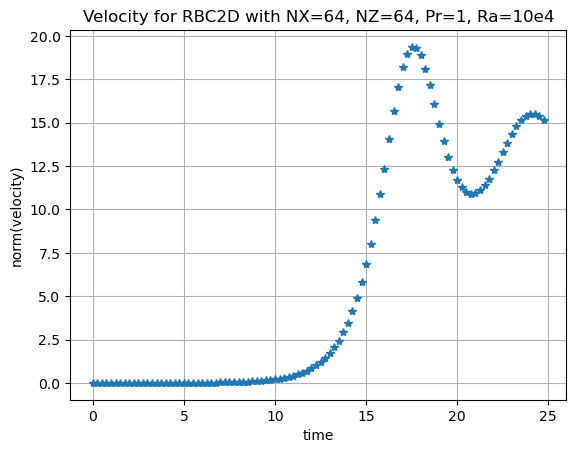

In [127]:
plt.title("Velocity for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(velocity)")
plt.grid()
plt.plot(time2[:100],vel2[:100],'*')
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/test_velocity.png")

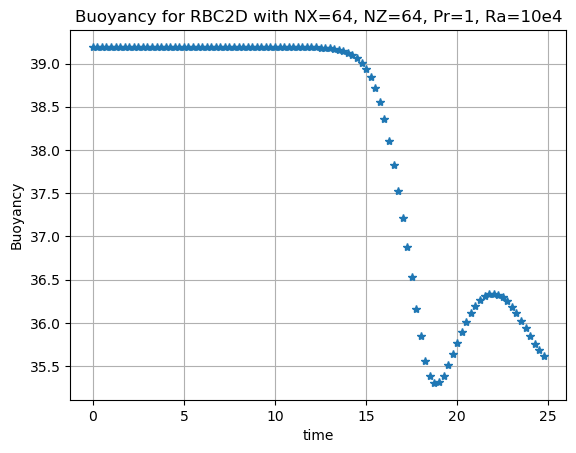

In [128]:
plt.title("Buoyancy for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("Buoyancy")
plt.grid()
plt.plot(time2[:100],b2[:100],'*')
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/test_buoyancy.png")

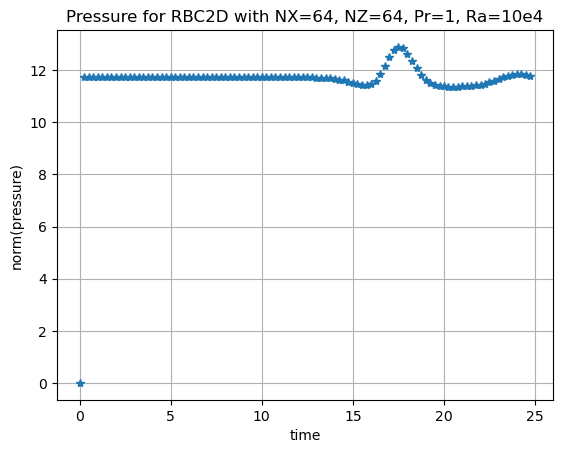

In [132]:
plt.title("Pressure for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(pressure)")
plt.grid()
plt.plot(time2[:100],p[:100],'*')
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/test_pressure.png")

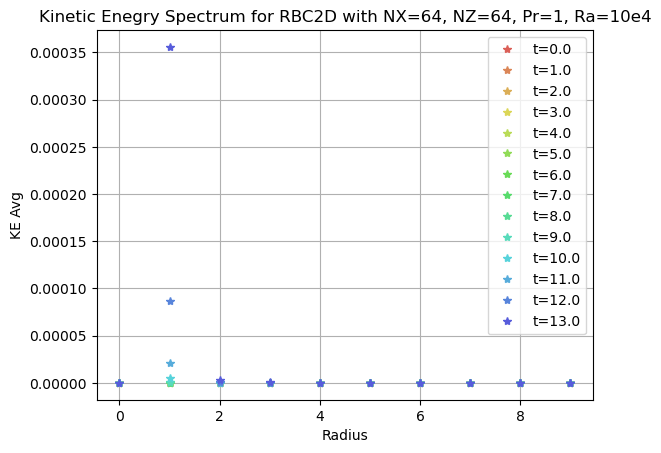

In [95]:
plot_KE(ke_energy2, time2, 0, 55, 4, 'test', '/p/project/cexalab/john2/NeuralOperators/neural_operators/TrainedModels_NX64_NZ64/FNO_RBC2D_juwelsbooster_channel4_run8')

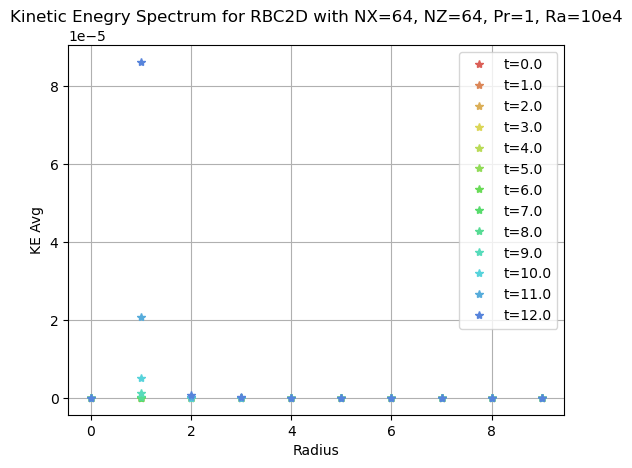

In [98]:
plot_KE(ke_energy2, time2, 0, 50, 4, 'test', '/p/project/cexalab/john2/NeuralOperators/neural_operators/TrainedModels_NX64_NZ64/FNO_RBC2D_juwelsbooster_channel4_run8')

### Train

In [151]:
ke_energy3 = []
time3 = []
file5 = '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4_train.h5'
vel3 = []
b3 = []
p3 = []
for t in range(1600):
    vel_t,b_t,v_t,p_t = rbc_tasks('multi',file5, t, 0 , 0)
    write_no, iteration, sim_time, time_step, wall_time = rbc_scales('multi', file5, t,0)
    vel3.append(np.linalg.norm(vel_t))
    b3.append(np.linalg.norm(b_t))
    p3.append(np.linalg.norm(p_t))
    ke_energy3.append(get_KESpectrum(vel_t))
    time3.append(sim_time)
ke_energy3 = np.array(ke_energy3)
print(ke_energy3.shape, len(time3))

(1600, 47) 1600


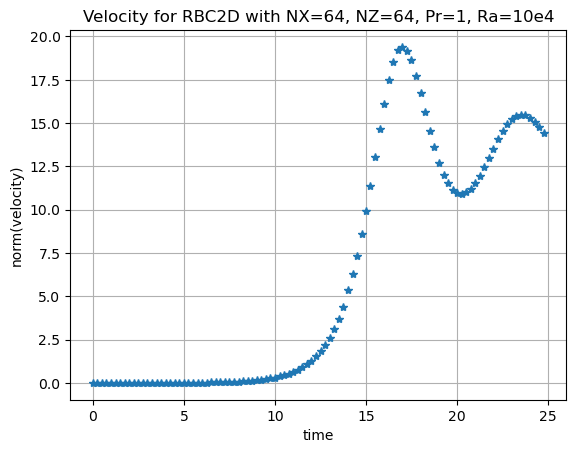

In [133]:
plt.title("Velocity for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(velocity)")
plt.grid()
plt.plot(time3[:100],vel3[:100],'*')
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/train_velocity.png")

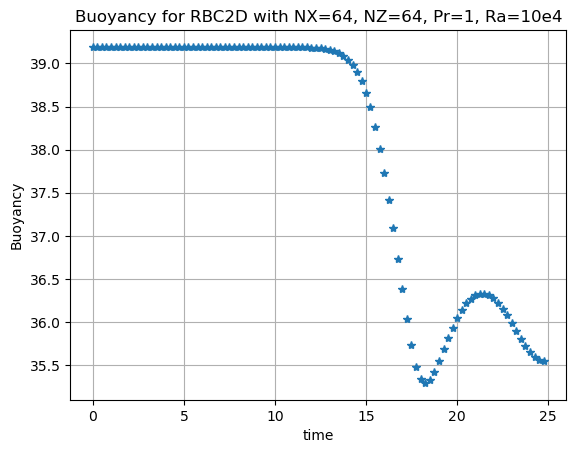

In [135]:
plt.title("Buoyancy for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("Buoyancy")
plt.grid()
plt.plot(time3[:100],b3[:100],'*')
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/train_buoyancy.png")

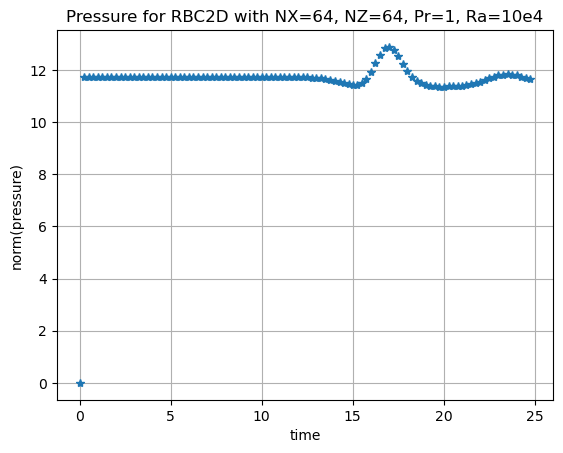

In [134]:
plt.title("Pressure for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(pressure)")
plt.grid()
plt.plot(time3[:100],p3[:100],'*')
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/train_pressure.png")

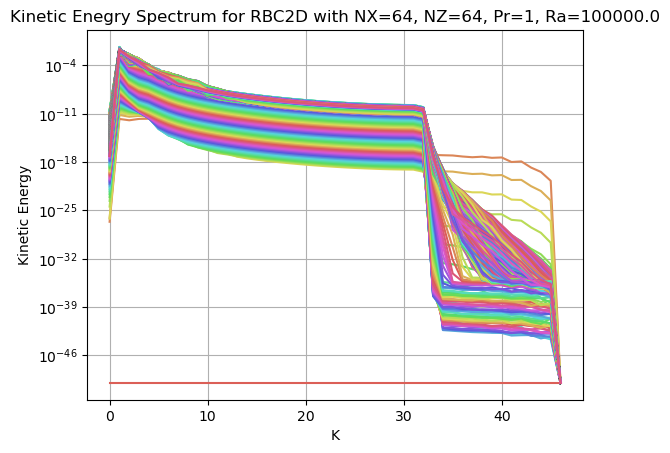

In [173]:
plot_KE(ke_energy3, time3,'/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4', 0, len(ke_energy3),1, False)

### Validation

In [136]:
ke_energy4 = []
time4 = []
file6 = '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4_val.h5'
vel4 = []
b4 = []
p4 = []
for t in range(1600):
    vel_t,b_t,v_t,p_t = rbc_tasks('multi',file6, 0, 0 , t)
    write_no, iteration, sim_time, time_step, wall_time = rbc_scales('multi', file6, 0,t)
    vel4.append(np.linalg.norm(vel_t))
    b4.append(np.linalg.norm(b_t))
    p4.append(np.linalg.norm(p_t))
    ke_energy4.append(get_KESpectrum(vel_t))
    time4.append(sim_time)
ke_energy4 = np.array(ke_energy4)
print(ke_energy4.shape, len(time4))

(1600, 47) 1600


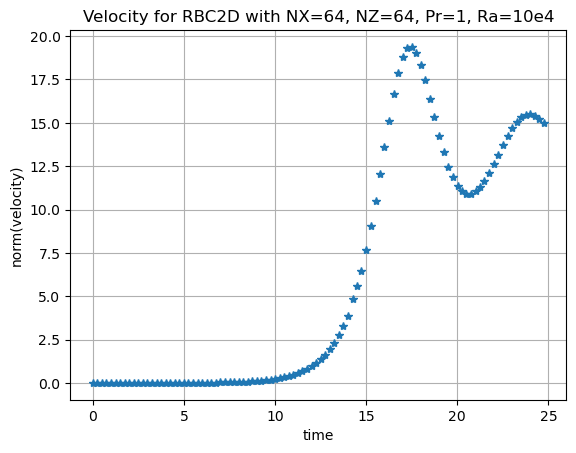

In [137]:
plt.title("Velocity for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(velocity)")
plt.grid()
plt.plot(time4[:100],vel4[:100],'*')
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/val_velocity.png")

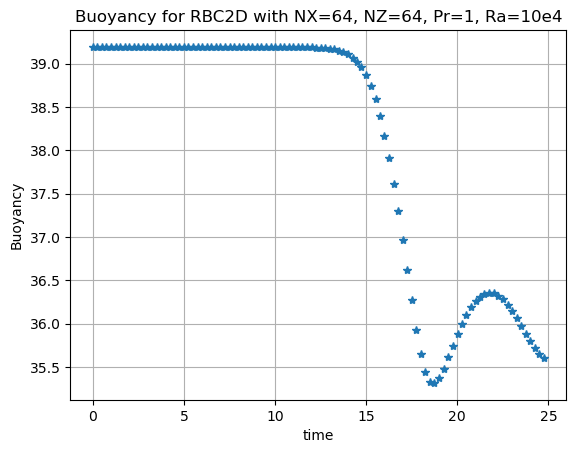

In [138]:
plt.title("Buoyancy for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("Buoyancy")
plt.grid()
plt.plot(time4[:100],b4[:100],'*')
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/val_buoyancy.png")

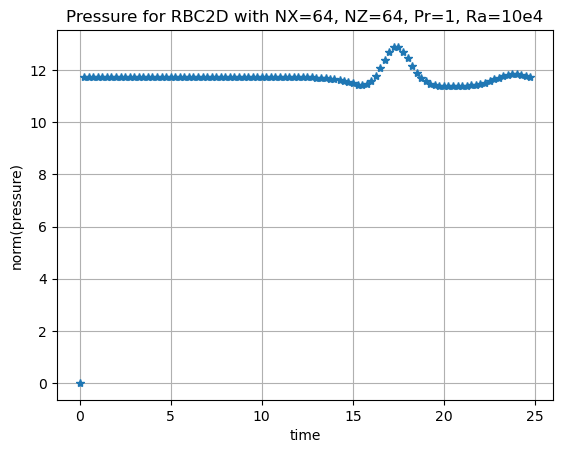

In [139]:
plt.title("Pressure for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(pressure)")
plt.grid()
plt.plot(time4[:100],p4[:100],'*')
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/val_pressure.png")

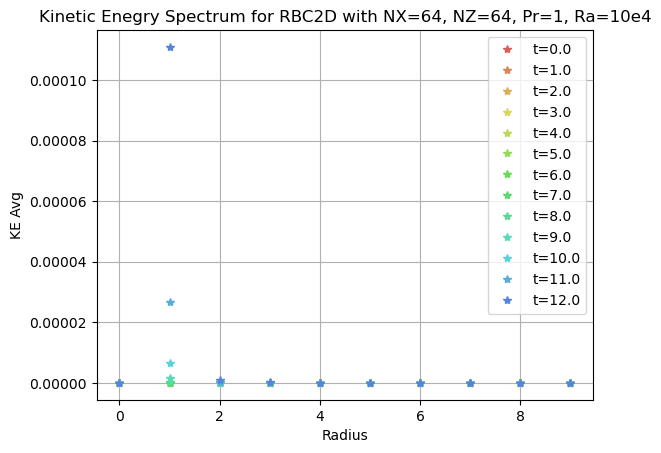

In [104]:
plot_KE(ke_energy4, time4, 0, 50, 4, 'val', '/p/project/cexalab/john2/NeuralOperators/neural_operators/TrainedModels_NX64_NZ64/FNO_RBC2D_juwelsbooster_channel4_run8')

## Timestep

In [14]:
indexrange,_,_,_,_ =rbc_scales('single', '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF200_Pr1_Ra10e7/snapshots_1_tf_200_seed_1/snapshots_1_tf_200_seed_1_s1.h5', -1)

In [30]:
ke_energy_10e7, simtime_10e7, timestep_10e7, iteration_10e7, write_10e7, walltime_10e7 = timestepfinder('/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF200_Pr1_Ra10e7/snapshots_1_tf_200_seed_1/snapshots_1_tf_200_seed_1_s1.h5',
        indexrange,0,'single')

/tmp/ipykernel_9123/4009576781.py:11: RuntimeWarning: overflow encountered in square
  EK_Ux  = Ux_ampl**2
/tmp/ipykernel_9123/4009576781.py:12: RuntimeWarning: overflow encountered in square
  EK_Uz  = Uz_ampl**2


(801, 47) 801


In [31]:
ke_energy_10e6, simtime_10e6, timestep_10e6,iteration_10e6, write_10e6, walltime_10e6 = timestepfinder('/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF200_Pr1_Ra10e6/snapshots_0_tf_200_seed_1/snapshots_0_tf_200_seed_1_s1.h5',
        indexrange,0,'single')

(801, 47) 801


In [32]:
ke_energy_10e5, simtime_10e5, timestep_10e5,iteration_10e5, write_10e5, walltime_10e5 = timestepfinder('/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e5/snapshots_1_tf_400_seed_30001_s1.h5',
        indexrange,0,'single')

(801, 47) 801


In [15]:
ke_energy_10e4, simtime_10e4, timestep_10e4 ,iteration_10e4, write_10e4, walltime_10e4= timestepfinder('/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4_train.h5',
        indexrange,0,'multi')

(801, 47) 801


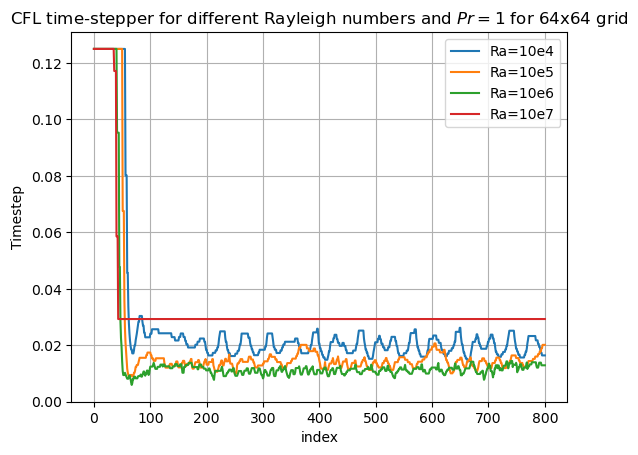

In [147]:
plt.title(f"CFL time-stepper for different Rayleigh numbers and $Pr=1$ for 64x64 grid")
plt.xlabel("index")
plt.ylabel("Timestep")
plt.plot(timestep_10e4,label=f"Ra=10e4")
plt.plot(timestep_10e5,label=f"Ra=10e5")
plt.plot(timestep_10e6,label=f"Ra=10e6")
plt.plot(timestep_10e7,label=f"Ra=10e7")
plt.grid()
plt.legend()
plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/Timestepper.png")

In [94]:
min(timestep_10e7[100:]), max(timestep_10e7)

(0.029294678374750346, 0.125)

In [95]:
min(timestep_10e6[100:]), max(timestep_10e6)

(0.007738285513578409, 0.125)

In [96]:
min(timestep_10e5[100:]), max(timestep_10e5)

(0.010011092535748162, 0.125)

In [106]:
min(timestep_10e4[100:]), max(timestep_10e4)

(0.014426464716065153, 0.125)

## Animation

In [37]:
gif = '/p/scratch/cexalab/john2/RayleighBenardConvection/frames.gif'
foldername= '/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF200_Pr1_Ra10e6/frames'
animate(gif,foldername)

## Fixed dt

### Fine Data

In [198]:
obj = ["test"]
start_t = 0
end_t = 50226
for mode in obj:
    foldername = f"/p/project/cexalab/john2/NeuralOperators/RayleighBernardConvection/RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine/{mode}"
    filename = f"/p/project/cexalab/john2/NeuralOperators/RayleighBernardConvection/RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine_{mode}.h5"
    print("File:",filename)
    data_process(filename,foldername, start_t, end_t)
    get_group(filename)

File: /p/project/cexalab/john2/NeuralOperators/RayleighBernardConvection/RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine_test.h5
Data: RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine_s1.h5
Keys 50226
Group: snapshots_0_t_0 <class 'h5py._hl.group.Group'>
No: of subgroup: 3
--------------------------------------
SubGroup: input  with Shape: 4
SubGroup: scales  with Shape: 5
SubGroup: tasks  with Shape: 4
--------------------------------------


In [1]:
file = '/p/project/cexalab/john2/NeuralOperators/RayleighBernardConvection/RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine/RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine_train.h5'

In [12]:
rbc_scales('multi',file,1999,0)

(2000, 1999, 25.03546351045288, 2e-05, 31.436550855636597)

## Train

In [43]:
ke_energy9 = []
time9 = []
file9 = '/p/project/cexalab/john2/NeuralOperators/RayleighBernardConvection/RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine/RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine_train.h5'
vel9 = []
b9 = []
timestep9 = []
p9 = []
for t in range(1600):
    vel_t,b_t,v_t,p_t = rbc_tasks('multi',file9, t, 0 , 0)
    write_no, iteration, sim_time, time_step, wall_time = rbc_scales('multi', file9, t,0)
    vel9.append(np.linalg.norm(vel_t))
    b9.append(np.linalg.norm(b_t))
    p9.append(np.linalg.norm(p_t))
    ke_energy9.append(get_KESpectrum(vel_t))
    timestep9.append(time_step)
    time9.append(sim_time)
ke_energy9 = np.array(ke_energy9)
print(ke_energy9.shape, len(time9))

(1600, 47) 1600


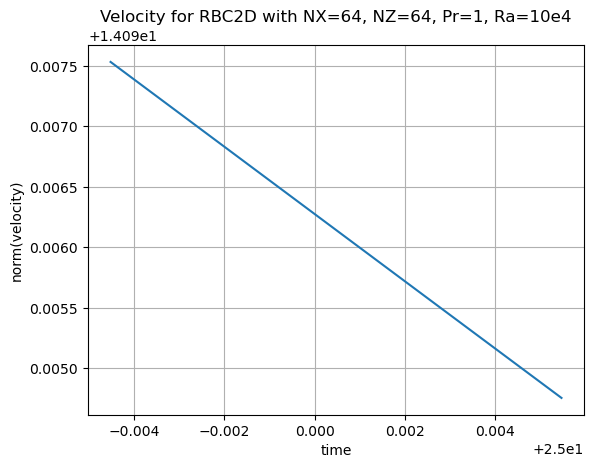

In [44]:
plt.title("Velocity for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(velocity)")
plt.grid()
plt.plot(time9[:500],vel9[:500])
# plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/val_velocity.png")

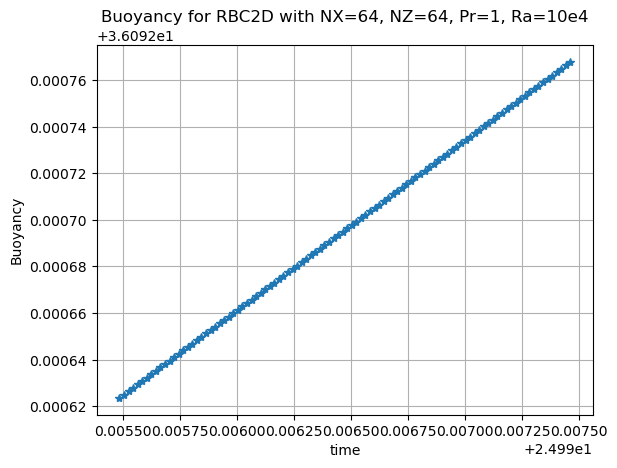

In [45]:
plt.title("Velocity for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(velocity)")
plt.grid()
plt.plot(time9[:500],vel9[:500])
# plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/val_velocity.png")

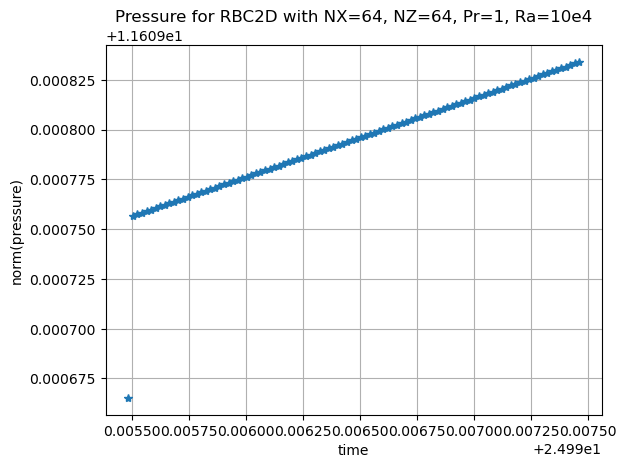

In [46]:
plt.title("Velocity for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(velocity)")
plt.grid()
plt.plot(time9[:500],vel9[:500])
# plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/val_velocity.png")

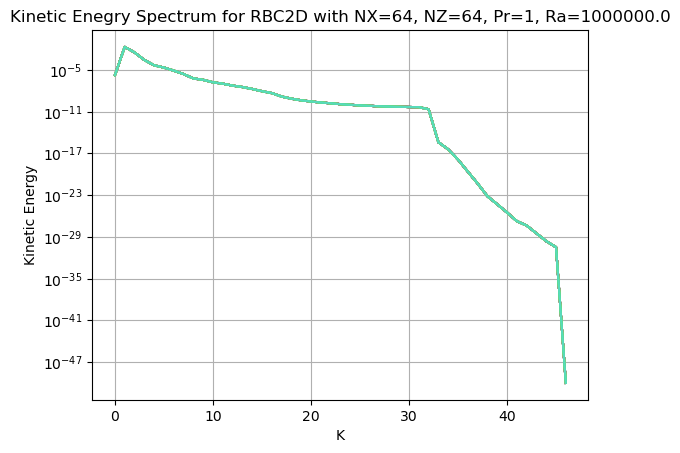

In [47]:
plot_KE(ke_energy9, time9, '/p/project/cexalab/john2/NeuralOperators/neural_operators/TrainedModels_NX64_NZ64',0,50,1,False,64,64,1,10e5)

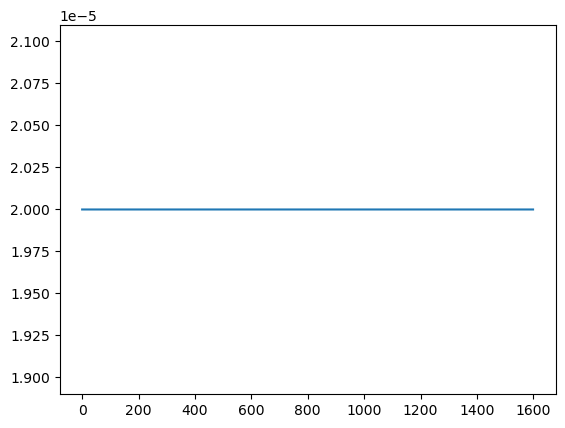

In [48]:
plt.plot(timestep9)

In [ ]:
## Validation

In [ ]:
ke_energy9 = []
time9 = []
file9 = '/p/project/cexalab/john2/NeuralOperators/RayleighBernardConvection/RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine/RBC2D_NX64_NZ64_T025_TF26_Pr1_Ra10e5_dt2_10e_5_fine_train.h5'
vel9 = []
b9 = []
timestep9 = []
p9 = []
for t in range(1600):
    vel_t,b_t,v_t,p_t = rbc_tasks('multi',file9, t, 0 , 0)
    write_no, iteration, sim_time, time_step, wall_time = rbc_scales('multi', file9, t,0)
    vel9.append(np.linalg.norm(vel_t))
    b9.append(np.linalg.norm(b_t))
    p9.append(np.linalg.norm(p_t))
    ke_energy9.append(get_KESpectrum(vel_t))
    timestep9.append(time_step)
    time9.append(sim_time)
ke_energy9 = np.array(ke_energy9)
print(ke_energy9.shape, len(time9))

In [ ]:
plt.title("Velocity for RBC2D with NX=64, NZ=64, Pr=1, Ra=10e4")
plt.xlabel("time")
plt.ylabel("norm(velocity)")
plt.grid()
plt.plot(time9[:500],vel9[:500])
# plt.savefig("/p/scratch/cexalab/john2/RayleighBenardConvection/RBC2D_NX64_NZ64_TF400_Pr1_Ra10e4/val_velocity.png")